In [1]:
import pandas as pd
from ebmdatalab import bq
import numpy as np

In [2]:
from ebmdatalab import bq

# save table in BQ as follows
'''SELECT pct, practice, chemical, bnf_code, bnf_name, SUM(items) AS items, SUM(actual_cost) AS actual_cost, SUM(quantity) AS quantity, CAST(month AS DATE) AS month 
FROM `ebmdatalab.hscic.normalised_prescribing_standard` p

LEFT JOIN `hscic.bnf` b ON p.bnf_code = b.presentation_code

WHERE SUBSTR(bnf_code,1,4) = '0212'

GROUP BY 
 pct, practice, chemical, bnf_code, bnf_name, month
 
ORDER BY
month, bnf_code'''


# Import practice-level data

sql = '''-- practice data by chemical

SELECT p.month, p.practice, chemical, 
SUM(items) AS items, SUM(actual_cost) AS actual_cost, SUM(quantity) AS quantity
FROM `ebmdatalab.helen.prescribing_section_2_12` p

INNER JOIN ebmdatalab.hscic.practices prac
ON p.practice = prac.code
  AND prac.setting = 4
  
GROUP BY
month, practice, chemical'''


#df = bq.cached_read(sql, csv_path='statins_practice_level.zip')  # add `use_cache=False` to override
df = pd.read_csv('helen_prescribing_lipid_reg_practice_level.csv')
df.head()

,month,practice,chemical,items,actual_cost,quantity
0,2012-07-01,J82080,Pravastatin Sodium,12,52.39000,700
1,2015-02-01,Y02570,Omega-3-Acid Ethyl Esters,1,26.35000,56
2,2017-02-01,L83134,Atorvastatin,260,261.59032,7196
3,2012-05-01,C82002,Simvastatin,519,869.46000,24339
4,2014-06-01,P81117,Bezafibrate,7,54.98000,480


In [3]:
prac = df.copy()
prac["month"]= pd.to_datetime(prac.month)
prac.head()

,month,practice,chemical,items,actual_cost,quantity
0,2012-07-01,J82080,Pravastatin Sodium,12,52.39000,700
1,2015-02-01,Y02570,Omega-3-Acid Ethyl Esters,1,26.35000,56
2,2017-02-01,L83134,Atorvastatin,260,261.59032,7196
3,2012-05-01,C82002,Simvastatin,519,869.46000,24339
4,2014-06-01,P81117,Bezafibrate,7,54.98000,480


### Practice population data

note running this cell takes some time

In [17]:
sql_prac_p = '''
SELECT practice, month, SUM(total_list_size) AS total_list_size,
SUM( female_75_plus+female_65_74+female_55_64+female_45_54+male_75_plus+male_65_74+male_55_64+male_45_54) AS list_size_over_45 FROM ebmdatalab.hscic.practice_statistics_all_years stat
GROUP BY practice, month'''

prac_p = bq.cached_read(sql_prac_p, csv_path='prac_p.csv', use_cache=False)  # add `use_cache=False` to override


prac_p["total_list_size"] = prac_p["total_list_size"].astype("float")
prac_p["list_size_over_45"] = prac_p["list_size_over_45"].astype("float")
prac_p["month"]= pd.to_datetime(prac_p.month)
prac_p.info()

C:\Users\hcurtis\Anaconda3\lib\site-packages\pandas\io\gbq.py:149: FutureWarning: verbose is deprecated and will be removed in a future version. Set logging level in order to vary verbosity
  credentials=credentials, verbose=verbose, private_key=private_key)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 892170 entries, 0 to 92169
Data columns (total 4 columns):
practice             892170 non-null object
month                892170 non-null datetime64[ns, UTC]
total_list_size      892170 non-null float64
list_size_over_45    892170 non-null float64
dtypes: datetime64[ns, UTC](1), float64(2), object(1)
memory usage: 34.0+ MB


## Deciles for practices

### Rearrange data to give items per 1000 for each chemical as a column
Also select top chemicals, grouping the rest into "other"

In [7]:
prac_deciles = prac.copy()

# group up chemicals to top 4 and "other"
conditions = [
    (prac_deciles["chemical"] == "Pravastatin Sodium"),
    (prac_deciles["chemical"] == "Rosuvastatin Calcium"),
    (prac_deciles["chemical"] == "Simvastatin"),
    (prac_deciles["chemical"] == "Atorvastatin")]
choices = ["Pravastatin Sodium","Rosuvastatin Calcium","Simvastatin","Atorvastatin"]
prac_deciles['chem2'] = np.select(conditions, choices, default='other')


prac_deciles = prac_deciles.groupby(["month","practice","chem2"],as_index=False).sum()

prac_deciles = prac_deciles.set_index(["month","practice","chem2"]).unstack()
prac_deciles["items","total"] = prac_deciles["items"].sum(axis=1)
prac_deciles["actual_cost","total"] = prac_deciles["actual_cost"].sum(axis=1)
prac_deciles.sort_index(axis=1,inplace=True)
prac_deciles = prac_deciles.stack().reset_index()

# join prac population data and calc items & cost per 1000
prac_deciles = prac_deciles.merge(prac_p, on=["practice","month"])
prac_deciles["items_per_thou"] = 1000*prac_deciles["items"]/prac_deciles["total_list_size"]
prac_deciles["cost_per_thou"] = 1000*prac_deciles["actual_cost"]/prac_deciles["total_list_size"]
prac_deciles["items_per_45+"] = 1000*prac_deciles["items"]/prac_deciles["list_size_over_45"]
prac_deciles["cost_per_45+"] = 1000*prac_deciles["actual_cost"]/prac_deciles["list_size_over_45"]

# reduce to required columns and set index
prac_deciles = prac_deciles[["month","practice","chem2","items_per_thou","cost_per_thou","items_per_45+","cost_per_45+"]].set_index(["month","practice","chem2"]).unstack().reset_index()#.fillna(0)


prac_deciles.columns = ['_'.join(tup).rstrip('_') for tup in prac_deciles.columns.values]

prac_deciles.head(-20)

ValueError: You are trying to merge on datetime64[ns] and datetime64[ns, UTC] columns. If you wish to proceed you should use pd.concat

### Plot practice deciles for items per 1000 patients

In [ ]:
import importlib
from ebmdatalab import charts
importlib.reload(charts)
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt

data = prac_deciles

# set sort order of drugs manually, and add grid refs to position each subplot:
s = [(0,'total',0,0,'(a) Total statins and other lipid-regulating drugs across practices'), 
     (1,'Atorvastatin',0,1,'(b) Atorvastatin items'),
     (2,'Simvastatin',1,0,'(c) Simvastatin items'),
     (3,'Rosuvastatin Calcium',1,1,'(d) Rosuvastatin items'),
     (4,'Pravastatin Sodium',2,0,'(e) Pravastatin items'),
     (5,'other',2,1,'(f) Other items')]


fig = plt.figure(figsize=(16,16)) 


gs = gridspec.GridSpec(3,2)  # grid layout for subplots

# Plot each subplot using a loop
for i in s:
    ax = plt.subplot(gs[i[2], i[3]])  # position of subplot in grid using coordinates listed in s
    if i[3]==2:
        legend = True
    else:
        legend = False
    
    plt = charts.deciles_chart(
        data,
        period_column='month',
        column="items_per_thou_"+i[1],
        title=i[4],
        ylabel="Items per 1000 patients",
        show_outer_percentiles=True,
        show_legend=legend,
        ax=ax)
    if i[0]==0:
        ax.set_ylim([0, 250])
    else:
        ax.set_ylim([0, 180])
# Now add a single line against the deciles
'''df_subject = pd.DataFrame(np.random.rand(12, 1), columns=['val']) * 100
df_subject['month'] = months
df_subject.set_index('month')

plt.plot(df_subject['month'], df_subject['val'], 'r--')'''
fig.autofmt_xdate()
plt.show()

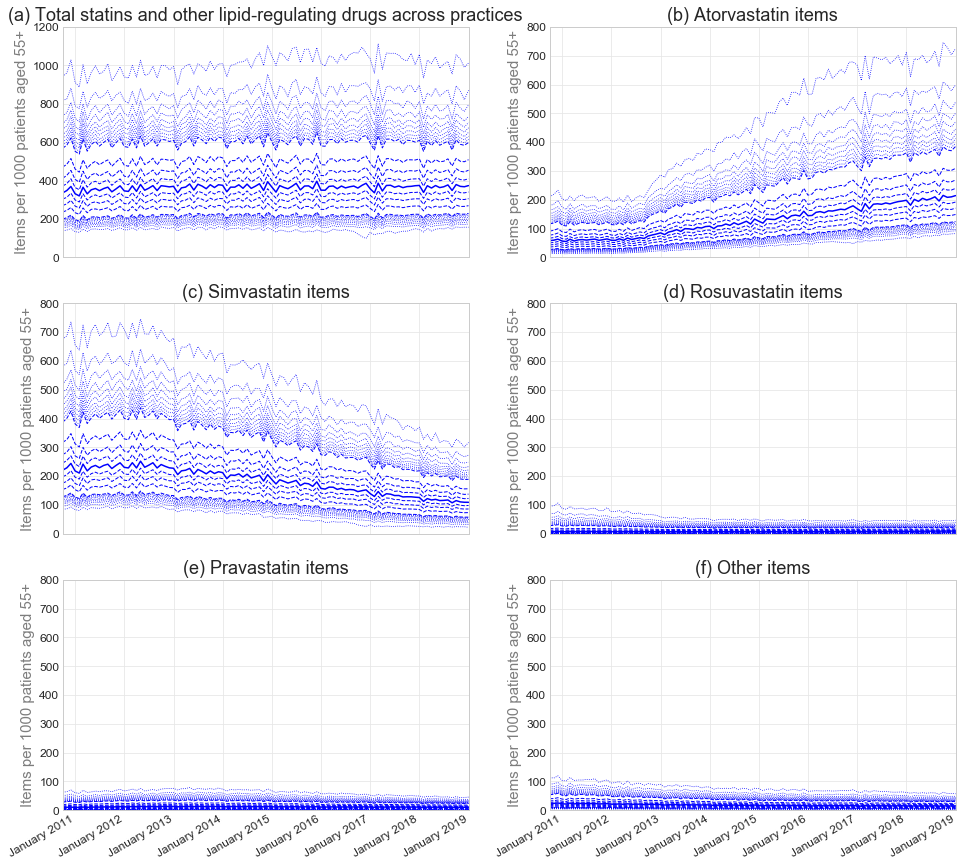

In [115]:
import importlib
from ebmdatalab import charts
importlib.reload(charts)
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt

data = prac_deciles

# set sort order of drugs manually, and add grid refs to position each subplot:
s = [(0,'total',0,0,'(a) Total statins and other lipid-regulating drugs across practices'), 
     (1,'Atorvastatin',0,1,'(b) Atorvastatin items'),
     (2,'Simvastatin',1,0,'(c) Simvastatin items'),
     (3,'Rosuvastatin Calcium',1,1,'(d) Rosuvastatin items'),
     (4,'Pravastatin Sodium',2,0,'(e) Pravastatin items'),
     (5,'other',2,1,'(f) Other items')]


fig = plt.figure(figsize=(16,16)) 


gs = gridspec.GridSpec(3,2)  # grid layout for subplots

# Plot each subplot using a loop
for i in s:
    ax = plt.subplot(gs[i[2], i[3]])  # position of subplot in grid using coordinates listed in s
    if i[3]==2:
        legend = True
    else:
        legend = False
    
    plt = charts.deciles_chart(
        data,
        period_column='month',
        column="items_per_45+_"+i[1],
        title=i[4],
        ylabel="Items per 1000 patients aged 45+",
        show_outer_percentiles=True,
        show_legend=legend,
        ax=ax)
    if i[0]==0:
        ax.set_ylim([0, 1200])
    else:
        ax.set_ylim([0, 800])
# Now add a single line against the deciles
'''df_subject = pd.DataFrame(np.random.rand(12, 1), columns=['val']) * 100
df_subject['month'] = months
df_subject.set_index('month')

plt.plot(df_subject['month'], df_subject['val'], 'r--')'''
fig.autofmt_xdate()
plt.show()

### Spend deciles

In [ ]:
# spend

data = prac_deciles

# set sort order of drugs manually, and add grid refs to position each subplot:
s = [(0,'total',0,0,'(a) Total statins and other lipid-regulating drugs across practices'), 
     (1,'Atorvastatin',0,1,'(b) Atorvastatin cost'),
     (2,'Simvastatin',1,0,'(c) Simvastatin cost'),
     (3,'Rosuvastatin Calcium',1,1,'(d) Rosuvastatin cost'),
     (4,'Pravastatin Sodium',2,0,'(e) Pravastatin cost'),
     (5,'other',2,1,'(f) Other cost')]


fig = plt.figure(figsize=(16,16)) 


gs = gridspec.GridSpec(3,2)  # grid layout for subplots

# Plot each subplot using a loop
for i in s:
    ax = plt.subplot(gs[i[2], i[3]])  # position of subplot in grid using coordinates listed in s
    if i[3]==2:
        legend = True
    else:
        legend = False
    
    plt = charts.deciles_chart(
        data,
        period_column='month',
        column="cost_per_thou_"+i[1],
        title=i[4],
        ylabel="Cost per 1000 patients",
        show_outer_percentiles=False,
        show_legend=legend,
        ax=ax)
    if i[0]==0:
        ax.set_ylim([0, 1500])
    else:
        ax.set_ylim([0, 900])
# Now add a single line against the deciles
'''df_subject = pd.DataFrame(np.random.rand(12, 1), columns=['val']) * 100
df_subject['month'] = months
df_subject.set_index('month')

plt.plot(df_subject['month'], df_subject['val'], 'r--')'''
fig.autofmt_xdate()
plt.show()

## Other category

In [ ]:
prac_other = prac.copy()

# group up chemicals to top 4 and "other"

prac_other = prac_other.groupby(["chemical"],as_index=False).sum()
prac_other["cost_rank"] = prac_other["actual_cost"].rank(ascending=False)
prac_other.sort_values(by="actual_cost")

In [119]:
prac_other = prac.copy()

# group up chemicals to top 4 and "other"
conditions = [
    (prac_other["chemical"] == "Pravastatin Sodium"),
    (prac_other["chemical"] == "Rosuvastatin Calcium"),
    (prac_other["chemical"] == "Simvastatin"),
    (prac_other["chemical"] == "Atorvastatin")]
choices = ["Pravastatin Sodium","Rosuvastatin Calcium","Simvastatin","Atorvastatin"]
prac_other['chem2'] = np.select(conditions, choices, default='other')


prac_other = prac_other.loc[prac_other["chem2"]=="other"].groupby(["month","practice","chemical"],as_index=False).sum()

prac_other = prac_other.set_index(["month","practice","chemical"]).unstack()
prac_other["items","total"] = prac_other["items"].sum(axis=1)
prac_other["actual_cost","total"] = prac_other["actual_cost"].sum(axis=1)
prac_other.sort_index(axis=1,inplace=True)
prac_other = prac_other.stack().reset_index()

# join prac population data and calc items & cost per 1000
prac_other = prac_other.merge(prac_p, on=["practice","month"])
prac_other["items_per_thou"] = 1000*prac_other["items"]/prac_other["total_list_size"]
prac_other["cost_per_thou"] = 1000*prac_other["actual_cost"]/prac_other["total_list_size"]
prac_other["items_per_55+"] = 1000*prac_other["items"]/prac_other["list_size_over_55"]
prac_other["cost_per_55+"] = 1000*prac_other["actual_cost"]/prac_other["list_size_over_55"]

# reduce to required columns and set index
prac_other = prac_other[["month","practice","chemical","items_per_thou","cost_per_thou","items_per_55+","cost_per_55+"]].set_index(["month","practice","chemical"]).unstack().reset_index()#.fillna(0)


prac_other.columns = ['_'.join(tup).rstrip('_') for tup in prac_other.columns.values]

prac_other.head(-20)

,month,practice,items_per_thou_Acipimox,items_per_thou_Alirocumab,items_per_thou_Bezafibrate,items_per_thou_Cerivastatin,items_per_thou_Ciprofibrate,items_per_thou_Colesevelam Hydrochloride,items_per_thou_Colestipol Hydrochloride,items_per_thou_Colestyramine,...,cost_per_55+_Gemfibrozil,cost_per_55+_Ispaghula Husk,cost_per_55+_Nicotinic Acid,cost_per_55+_Nicotinic Acid/Laropiprant,cost_per_55+_Omega-3 Marine Triglycerides,cost_per_55+_Omega-3-Acid Ethyl Esters,cost_per_55+_Other Lipid-Regulating Preps,cost_per_55+_Policosanol,cost_per_55+_Simvastatin & Ezetimibe,cost_per_55+_total
0,2010-10-01,A81001,NaN,NaN,0.943174,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,385.918231
1,2010-10-01,A81002,NaN,NaN,0.340881,NaN,NaN,NaN,NaN,0.243487,...,NaN,NaN,NaN,NaN,4.641869,8.069474,NaN,NaN,NaN,420.459576
2,2010-10-01,A81003,NaN,NaN,0.269833,NaN,NaN,NaN,NaN,0.269833,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,226.806283
3,2010-10-01,A81004,NaN,NaN,0.123518,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,20.808824,19.279412,NaN,NaN,NaN,715.856618
4,2010-10-01,A81005,NaN,NaN,1.003764,NaN,NaN,NaN,NaN,0.501882,...,19.116791,NaN,NaN,NaN,NaN,33.921061,NaN,NaN,NaN,552.607570
5,2010-10-01,A81006,NaN,NaN,0.406207,NaN,NaN,NaN,NaN,0.406207,...,8.183329,NaN,NaN,NaN,NaN,18.175021,NaN,NaN,67.319302,381.406813
6,2010-10-01,A81007,NaN,NaN,4.722308,NaN,NaN,NaN,NaN,NaN,...,23.941499,NaN,NaN,NaN,27.586837,9.601463,NaN,NaN,74.968921,657.861060
7,2010-10-01,A81008,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.462107,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,95.833333,308.737374
8,2010-10-01,A81009,NaN,NaN,0.105899,NaN,NaN,0.105899,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,44.695356,NaN,NaN,15.291862,242.956966
9,2010-10-01,A81011,NaN,NaN,0.288351,NaN,NaN,NaN,NaN,0.480584,...,21.375039,NaN,NaN,NaN,NaN,168.727160,NaN,NaN,NaN,528.104676


In [ ]:
data = prac_deciles

# set sort order of drugs manually, and add grid refs to position each subplot:
s = [(0,'total',0,0,'(a) Total statins and other lipid-regulating drugs across practices'), 
     (1,'Atorvastatin',0,1,'(b) Atorvastatin cost'),
     (2,'Simvastatin',1,0,'(c) Simvastatin cost'),
     (3,'Rosuvastatin Calcium',1,1,'(d) Rosuvastatin cost'),
     (4,'Pravastatin Sodium',2,0,'(e) Pravastatin cost'),
     (5,'other',2,1,'(f) Other cost')]


fig = plt.figure(figsize=(16,16)) 


gs = gridspec.GridSpec(3,2)  # grid layout for subplots

# Plot each subplot using a loop
for i in s:
    ax = plt.subplot(gs[i[2], i[3]])  # position of subplot in grid using coordinates listed in s
    if i[3]==2:
        legend = True
    else:
        legend = False
    
    plt = charts.deciles_chart(
        data,
        period_column='month',
        column="cost_per_thou_"+i[1],
        title=i[4],
        ylabel="Cost per 1000 patients",
        show_outer_percentiles=False,
        show_legend=legend,
        ax=ax)
    if i[0]==0:
        ax.set_ylim([0, 1500])
    else:
        ax.set_ylim([0, 900])
# Now add a single line against the deciles
'''df_subject = pd.DataFrame(np.random.rand(12, 1), columns=['val']) * 100
df_subject['month'] = months
df_subject.set_index('month')

plt.plot(df_subject['month'], df_subject['val'], 'r--')'''
fig.autofmt_xdate()
plt.show()

# CCG data

In [10]:
sql = '''-- CCG data by chemical
SELECT p.month, p.pct, chemical, 
SUM(items) AS items, 
SUM(actual_cost) AS actual_cost, 
SUM(quantity) AS quantity 

FROM `ebmdatalab.helen.prescribing_section_2_12` p

INNER JOIN ebmdatalab.hscic.ccgs c
ON p.pct = c.code
  AND c. org_type = "CCG"

GROUP BY
month, pct, chemical'''


ccg = bq.cached_read(sql, csv_path='statins_ccg_level.csv')  # add `use_cache=False` to override
ccg["month"]= pd.to_datetime(ccg.month)
ccg.head()



,month,pct,chemical,items,actual_cost,quantity
0,2014-03-01,08Q,Rosuvastatin Calcium,373,10756.01,15889
1,2014-03-01,01C,Simvastatin & Ezetimibe,1,38.09,28
2,2014-03-01,99P,Acipimox,3,125.76,264
3,2014-03-01,06K,Atorvastatin,20220,34625.87,581145
4,2014-03-01,10K,Ciprofibrate,27,3626.37,1344


### CCG population data

In [8]:
sql_ccg_p = '''
SELECT pct_id AS pct, month, SUM(total_list_size) AS total_list_size,
SUM( female_75_plus+female_65_74+female_55_64+male_75_plus+male_65_74+male_55_64) AS list_size_over_55 FROM ebmdatalab.hscic.practice_statistics_all_years stat
GROUP BY pct, month'''

ccg_p = bq.cached_read(sql_ccg_p, csv_path='ccg_p.csv', use_cache=False)  # add `use_cache=False` to override


ccg_p["total_list_size"] = ccg_p["total_list_size"].astype("float")
ccg_p["list_size_over_55"] = ccg_p["list_size_over_55"].astype("float")
ccg_p["month"]= pd.to_datetime(ccg_p.month)
ccg_p.info()

C:\Users\hcurtis\Anaconda3\lib\site-packages\pandas\io\gbq.py:149: FutureWarning: verbose is deprecated and will be removed in a future version. Set logging level in order to vary verbosity
  credentials=credentials, verbose=verbose, private_key=private_key)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30598 entries, 0 to 30597
Data columns (total 4 columns):
pct                  30563 non-null object
month                30598 non-null datetime64[ns, UTC]
total_list_size      30598 non-null float64
list_size_over_55    30598 non-null float64
dtypes: datetime64[ns, UTC](1), float64(2), object(1)
memory usage: 956.3+ KB


# Maps

In [23]:
import numpy as np
import pandas as pd
from ebmdatalab import maps

# total items per thousand over last year

import datetime as dt
ccg_last_year =  ccg.copy()
ccg_last_year =  ccg_last_year.loc[pd.DatetimeIndex(ccg_last_year['month']).year==2018]
# join on list sizes:
ccg_last_year["month"] = pd.to_datetime(ccg_last_year["month"], utc = True)
ccg_p["month"] = pd.to_datetime(ccg_p["month"], utc = True)
ccg_last_year = ccg_last_year.merge(ccg_p, on=["pct","month"])

ccg_last_year = ccg_last_year.groupby(['pct']).agg({"items":"sum","total_list_size":"mean","list_size_over_55":"mean"}).reset_index()
ccg_last_year["items_per_thou"] = 1000*ccg_last_year["items"]/ccg_last_year["total_list_size"]
ccg_last_year["items_per_55+"] = 1000*ccg_last_year["items"]/ccg_last_year["list_size_over_55"]
#ccg_last_year["cost_per_55+"] = 1000*ccg_last_year["actual_cost"]/ccg_last_year["list_size_over_55"]
ccg_last_year.sort_values(by="items_per_thou").describe()


,items,total_list_size,list_size_over_55,items_per_thou,items_per_55+
count,1.950000e+02,1.950000e+02,195.000000,195.000000,195.000000
mean,3.743369e+05,3.035664e+05,88108.096572,1287.204058,4405.056640
std,2.088908e+05,1.813134e+05,53587.147747,362.288657,1207.256880
min,9.340500e+04,7.897006e+04,17678.780347,514.729698,2486.538978
25%,2.200335e+05,1.879890e+05,56159.071835,992.637298,3597.829360
50%,3.234200e+05,2.597903e+05,72473.450000,1287.561976,4218.239763
75%,4.685255e+05,3.350260e+05,101118.173857,1496.764103,5079.479771
max,1.251592e+06,1.314049e+06,331025.500000,2318.566931,11268.964903


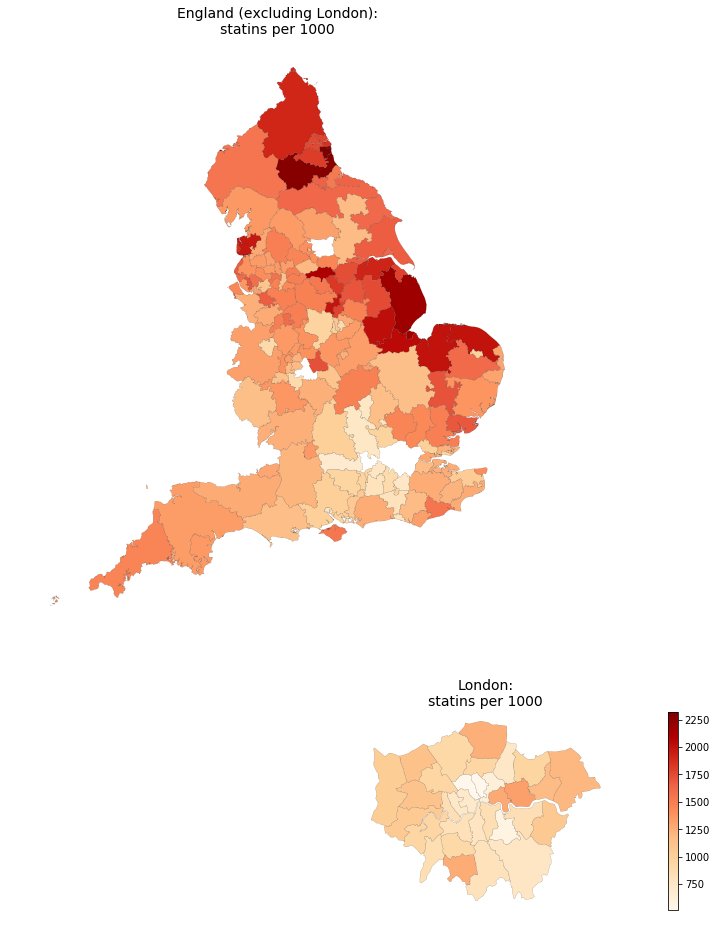

In [20]:
import matplotlib.pyplot as plt 
import importlib
from ebmdatalab import maps
importlib.reload(maps)

plt.figure(figsize=(20,16))
data = ccg_last_year
#df.columns = ['month', 'pct', 'ccg_name', 'total_list_size']  # The CCG column must be named 'pct'
plt = maps.ccg_map(data, title="statins per 1000", column='items_per_thou', separate_london=True)
plt.show()

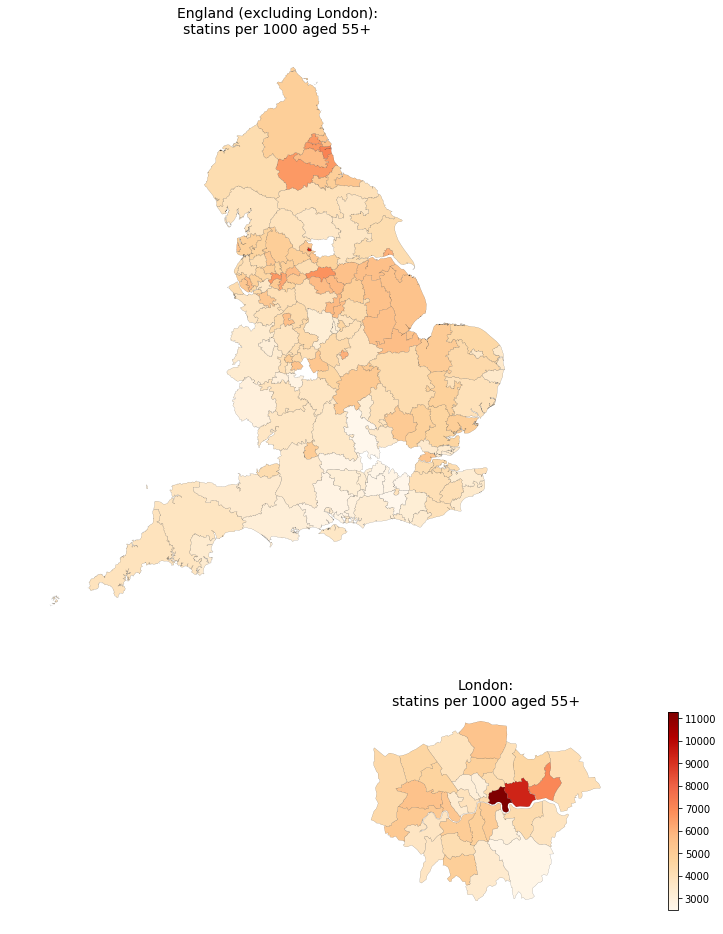

In [26]:
import matplotlib.pyplot as plt 
import importlib
from ebmdatalab import maps
importlib.reload(maps)

plt.figure(figsize=(20,16))
data = ccg_last_year
#df.columns = ['month', 'pct', 'ccg_name', 'total_list_size']  # The CCG column must be named 'pct'
plt = maps.ccg_map(data, title="statins per 1000 aged 55+", column='items_per_55+', separate_london=True)
plt.show()

In [6]:
# Maps for measure 

sql = '''-- statin intensity measure

SELECT * FROM measures.ccg_data_statinintensity2
WHERE EXTRACT(year from month) = 2018

'''


intensity = bq.cached_read(sql, csv_path='ccg_statin_intensity.csv')  # add `use_cache=False` to override
intensity.head()

C:\Users\hcurtis\Anaconda3\lib\site-packages\pandas\io\gbq.py:149: FutureWarning: verbose is deprecated and will be removed in a future version. Set logging level in order to vary verbosity
  credentials=credentials, verbose=verbose, private_key=private_key)


,pct_id,stp_id,regional_team_id,month,numerator,denominator,calc_value,percentile
0,02N,E54000005,Y54,2018-07-01,7098,17138,0.414167,0.103093
1,02N,E54000005,Y54,2018-01-01,7751,17646,0.439250,0.103093
2,02N,E54000005,Y54,2018-02-01,6614,15246,0.433819,0.097938
3,02N,E54000005,Y54,2018-05-01,7528,17712,0.425023,0.103093
4,02N,E54000005,Y54,2018-04-01,7290,16963,0.429759,0.108247


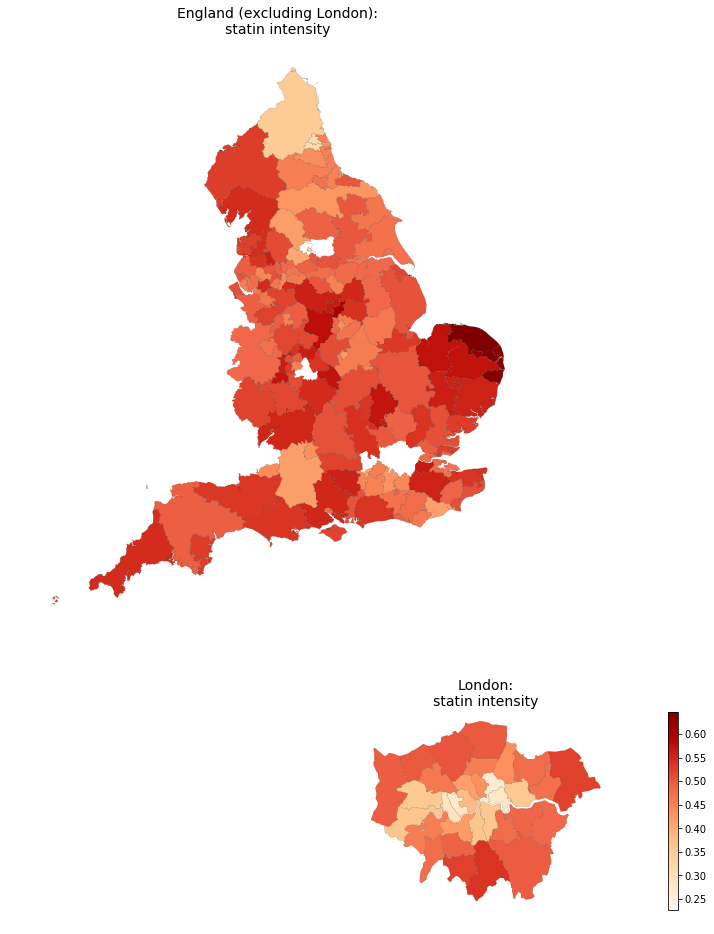

In [15]:
import matplotlib.pyplot as plt 
import importlib
from ebmdatalab import maps
importlib.reload(maps)

plt.figure(figsize=(20,16))
data = intensity.groupby("pct_id")["numerator","denominator"].sum().reset_index().rename(columns={"pct_id":"pct"})
data["calc_value"] = data["numerator"]/data["denominator"]

#df.columns = ['month', 'pct', 'ccg_name', 'total_list_size']  # The CCG column must be named 'pct'
plt = maps.ccg_map(data, title="statin intensity", column='calc_value', separate_london=True)
plt.show()

## Deciles for CCGs

### Rearrange data to give items per 1000 for each chemical as a column
Also select top chemicals, grouping the rest into "other"

In [91]:
ccg_deciles = ccg.copy()

# group up chemicals to top 4 and "other"
conditions = [
    (ccg_deciles["chemical"] == "Pravastatin Sodium"),
    (ccg_deciles["chemical"] == "Rosuvastatin Calcium"),
    (ccg_deciles["chemical"] == "Simvastatin"),
    (ccg_deciles["chemical"] == "Atorvastatin")]
choices = ["Pravastatin Sodium","Rosuvastatin Calcium","Simvastatin","Atorvastatin"]
ccg_deciles['chem2'] = np.select(conditions, choices, default='other')


ccg_deciles = ccg_deciles.groupby(["month","pct","chem2"],as_index=False).sum()

ccg_deciles = ccg_deciles.set_index(["month","pct","chem2"]).unstack()
ccg_deciles["items","total"] = ccg_deciles["items"].sum(axis=1)
ccg_deciles["actual_cost","total"] = ccg_deciles["actual_cost"].sum(axis=1)
ccg_deciles.sort_index(axis=1,inplace=True)
ccg_deciles = ccg_deciles.stack().reset_index()

# join CCG population data and calc items & cost per 1000
ccg_deciles = ccg_deciles.merge(ccg_p, on=["pct","month"])
ccg_deciles["items_per_thou"] = 1000*ccg_deciles["items"]/ccg_deciles["total_list_size"]
ccg_deciles["cost_per_thou"] = 1000*ccg_deciles["actual_cost"]/ccg_deciles["total_list_size"]

# reduce to required columns and set index
ccg_deciles = ccg_deciles[["month","pct","chem2","items_per_thou","cost_per_thou"]].set_index(["month","pct","chem2"]).unstack().reset_index()#.fillna(0)


ccg_deciles.columns = ['_'.join(tup).rstrip('_') for tup in ccg_deciles.columns.values]

ccg_deciles.head(-20)

,month,pct,items_per_thou_Atorvastatin,items_per_thou_Pravastatin Sodium,items_per_thou_Rosuvastatin Calcium,items_per_thou_Simvastatin,items_per_thou_other,items_per_thou_total,cost_per_thou_Atorvastatin,cost_per_thou_Pravastatin Sodium,cost_per_thou_Rosuvastatin Calcium,cost_per_thou_Simvastatin,cost_per_thou_other,cost_per_thou_total
0,2010-10-01,00C,18.519567,3.160497,3.934111,76.087777,6.132307,107.834258,410.574739,8.254368,94.791973,110.511151,121.648364,745.780595
1,2010-10-01,00D,21.089723,3.492344,5.575924,92.293190,8.918695,131.369875,456.504421,8.159423,117.493339,125.240638,187.098120,894.495941
2,2010-10-01,00J,15.776030,4.503264,3.760371,72.619823,8.839585,105.499073,371.802391,11.460326,84.499841,107.275755,176.126400,751.164713
3,2010-10-01,00K,16.494476,2.510869,2.451170,72.959173,5.495818,99.911505,443.806056,7.524459,61.500727,118.983432,142.208054,774.022728
4,2010-10-01,00L,19.073025,4.174662,1.310432,91.742719,7.653547,123.954384,460.685886,10.918238,31.152743,138.947754,151.760534,793.465157
5,2010-10-01,00M,20.849794,3.536459,3.056113,78.926392,5.510054,111.878814,502.417358,8.626803,68.192124,108.630805,127.220433,815.087524
6,2010-10-01,00N,19.082996,4.407793,0.909026,91.236079,11.392248,127.028141,486.756152,12.193106,21.369097,140.831791,237.400514,898.550660
7,2010-10-01,00P,23.230073,2.333970,3.200368,92.531296,10.407384,131.703091,493.311161,5.585331,72.931784,140.874638,230.544345,943.247259
8,2010-10-01,00Q,13.888035,6.507712,1.462545,70.583175,6.323358,98.764825,331.896700,18.252566,31.196215,101.169729,136.570085,619.085295
9,2010-10-01,00R,23.963875,6.705892,3.370562,93.694582,11.967257,139.702169,509.889370,16.660912,62.464503,115.324431,207.029619,911.368836


### Plot CCG deciles

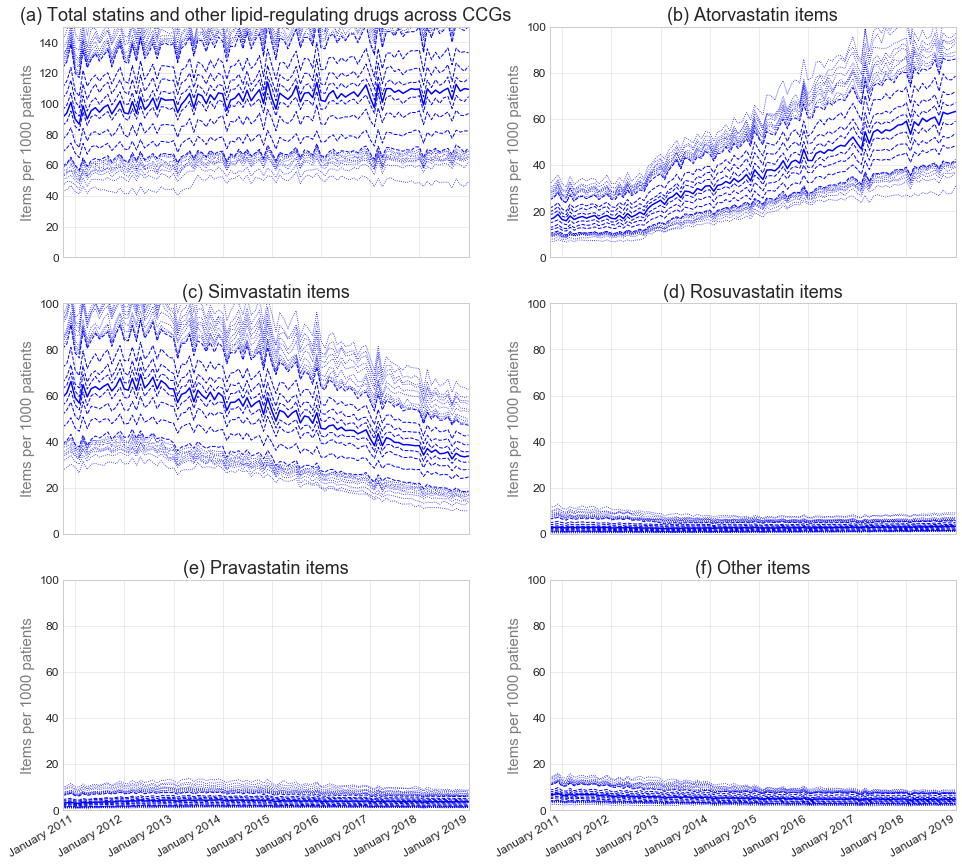

In [96]:
import importlib
from ebmdatalab import charts
importlib.reload(charts)
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt

data = ccg_deciles

# set sort order of drugs manually, and add grid refs to position each subplot:
s = [(0,'total',0,0,'(a) Total statins and other lipid-regulating drugs across CCGs'), 
     (1,'Atorvastatin',0,1,'(b) Atorvastatin items'),
     (2,'Simvastatin',1,0,'(c) Simvastatin items'),
     (3,'Rosuvastatin Calcium',1,1,'(d) Rosuvastatin items'),
     (4,'Pravastatin Sodium',2,0,'(e) Pravastatin items'),
     (5,'other',2,1,'(f) Other items')]


fig = plt.figure(figsize=(16,16)) 


gs = gridspec.GridSpec(3,2)  # grid layout for subplots

# Plot each subplot using a loop
for i in s:
    ax = plt.subplot(gs[i[2], i[3]])  # position of subplot in grid using coordinates listed in s
    if i[3]==2:
        legend = True
    else:
        legend = False
    
    plt = charts.deciles_chart(
        data,
        period_column='month',
        column="items_per_thou_"+i[1],
        title=i[4],
        ylabel="Items per 1000 patients",
        show_outer_percentiles=True,
        show_legend=legend,
        ax=ax)
    if i[0]==0:
        ax.set_ylim([0, 150])
    else:
        ax.set_ylim([0, 120])
# Now add a single line against the deciles
'''df_subject = pd.DataFrame(np.random.rand(12, 1), columns=['val']) * 100
df_subject['month'] = months
df_subject.set_index('month')

plt.plot(df_subject['month'], df_subject['val'], 'r--')'''
fig.autofmt_xdate()
plt.show()

### Spend deciles

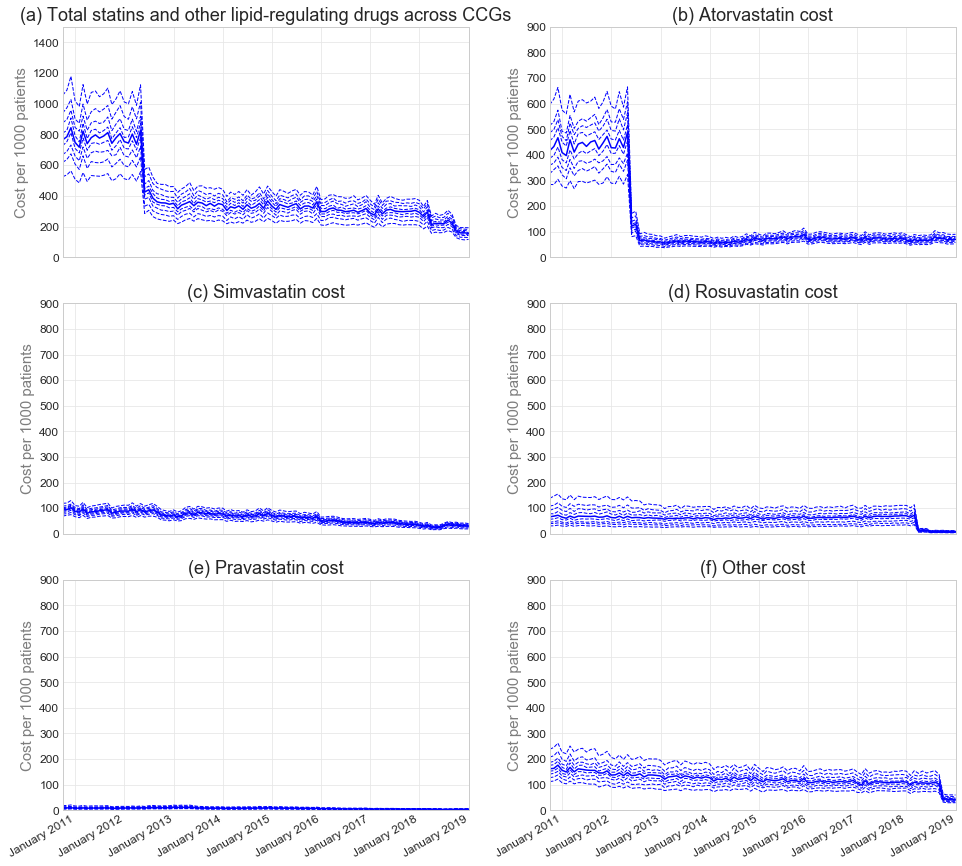

In [101]:
# spend

data = ccg_deciles

# set sort order of drugs manually, and add grid refs to position each subplot:
s = [(0,'total',0,0,'(a) Total statins and other lipid-regulating drugs across CCGs'), 
     (1,'Atorvastatin',0,1,'(b) Atorvastatin cost'),
     (2,'Simvastatin',1,0,'(c) Simvastatin cost'),
     (3,'Rosuvastatin Calcium',1,1,'(d) Rosuvastatin cost'),
     (4,'Pravastatin Sodium',2,0,'(e) Pravastatin cost'),
     (5,'other',2,1,'(f) Other cost')]


fig = plt.figure(figsize=(16,16)) 


gs = gridspec.GridSpec(3,2)  # grid layout for subplots

# Plot each subplot using a loop
for i in s:
    ax = plt.subplot(gs[i[2], i[3]])  # position of subplot in grid using coordinates listed in s
    if i[3]==2:
        legend = True
    else:
        legend = False
    
    plt = charts.deciles_chart(
        data,
        period_column='month',
        column="cost_per_thou_"+i[1],
        title=i[4],
        ylabel="Cost per 1000 patients",
        show_outer_percentiles=False,
        show_legend=legend,
        ax=ax)
    if i[0]==0:
        ax.set_ylim([0, 1500])
    else:
        ax.set_ylim([0, 900])
# Now add a single line against the deciles
'''df_subject = pd.DataFrame(np.random.rand(12, 1), columns=['val']) * 100
df_subject['month'] = months
df_subject.set_index('month')

plt.plot(df_subject['month'], df_subject['val'], 'r--')'''
fig.autofmt_xdate()
plt.show()

In [39]:

sql = '''SELECT p.practice, p.month, 
SUM(CASE WHEN bnf_code LIKE '0212000B0%AB' THEN items ELSE 0 END)/SUM(items) AS atorvastatin_20mg_items, 
SUM(CASE WHEN bnf_code LIKE '0212000B0%AD' THEN items ELSE 0 END)/SUM(items) AS atorvastatin_80mg_items, 
SUM(CASE WHEN bnf_code LIKE '0212000Y0%AB' OR bnf_code LIKE '0212000Y0%AE' THEN items ELSE 0 END)/SUM(items) AS simvastatin_20mg_items, 
SUM(CASE WHEN bnf_code LIKE '0212000Y0%AD' THEN items ELSE 0 END)/SUM(items) AS simvastatin_40mg_items, 
SUM(CASE WHEN bnf_code LIKE '0212000B0%AB' THEN quantity ELSE 0 END)/SUM(quantity) AS atorvastatin_20mg_quant, 
SUM(CASE WHEN bnf_code LIKE '0212000B0%AD' THEN quantity ELSE 0 END)/SUM(quantity) AS atorvastatin_80mg_quant, 
SUM(CASE WHEN bnf_code LIKE '0212000Y0%AB' OR bnf_code LIKE '0212000Y0%AE' THEN quantity ELSE 0 END)/SUM(quantity) AS simvastatin_20mg_quant, 

SUM(items) as total_items,
SUM(quantity) as total_quantity

FROM `ebmdatalab.helen.prescribing_section_2_12` p

INNER JOIN ebmdatalab.hscic.practices prac
ON p.practice = prac.code
  AND prac.setting = 4
  
WHERE SUBSTR(bnf_code,1,9) IN (
    '0212000AA', --Rosuvastatin Calcium
    '0212000AC', --Simvastatin & Ezetimibe
    '0212000B0', --Atorvastatin
    '0212000C0', --Cerivastatin
    '0212000M0', --Fluvastatin Sodium
    '0212000X0', --Pravastatin Sodium
    '0212000Y0') --Simvastatin
  
GROUP BY
practice, month'''

dose = bq.cached_read(sql, csv_path='statins_dose_practice_level.zip')  # add `use_cache=False` to override
dose["month"] = pd.to_datetime(dose.month)

dose.head()

C:\Users\hcurtis\Anaconda3\lib\site-packages\pandas\io\gbq.py:149: FutureWarning: verbose is deprecated and will be removed in a future version. Set logging level in order to vary verbosity
  credentials=credentials, verbose=verbose, private_key=private_key)


,practice,month,atorvastatin_20mg_items,atorvastatin_80mg_items,simvastatin_20mg_items,simvastatin_40mg_items,atorvastatin_20mg_quant,atorvastatin_80mg_quant,simvastatin_20mg_quant,total_items,total_quantity
0,C84121,2014-03-01,0.131579,0.035088,0.269006,0.421053,0.130058,0.034682,0.268786,342,9688
1,P82021,2014-03-01,0.047718,0.066390,0.165975,0.365145,0.045699,0.056452,0.176411,482,20832
2,M83601,2014-03-01,0.079208,0.047030,0.339109,0.334158,0.078873,0.041274,0.329333,404,16330
3,L85001,2014-03-01,0.086379,0.016611,0.291251,0.336656,0.086470,0.015552,0.294868,903,45010
4,A86004,2014-03-01,0.052409,0.064243,0.138631,0.425190,0.053183,0.059431,0.142249,1183,43698


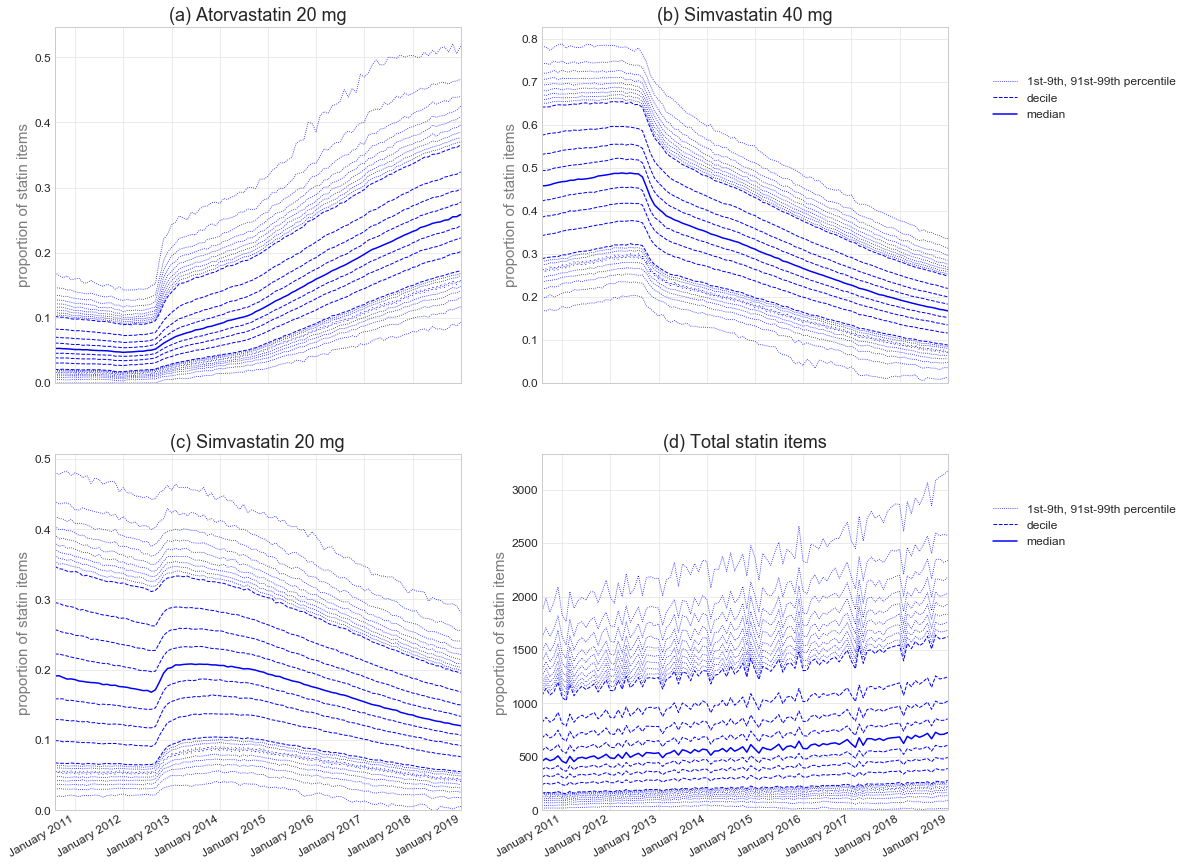

In [41]:
import importlib
from ebmdatalab import charts
importlib.reload(charts)
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt

data = dose.copy()

# set sort order of drugs manually, and add grid refs to position each subplot:
s = [(0,'atorvastatin_20mg_items',0,0,'(a) Atorvastatin 20 mg'), 
     (1,'simvastatin_40mg_items',0,1,'(b) Simvastatin 40 mg'),
     (2,'simvastatin_20mg_items',1,0,'(c) Simvastatin 20 mg'),
     (3,'total_items',1,1,'(d) Total statin items')]


fig = plt.figure(figsize=(16,16)) 


gs = gridspec.GridSpec(2,2)  # grid layout for subplots

# Plot each subplot using a loop
for i in s:
    ax = plt.subplot(gs[i[2], i[3]])  # position of subplot in grid using coordinates listed in s
    if i[3]==1: # set positions at which to display the legend
        legend = True
    else:
        legend = False
    
    plt = charts.deciles_chart(
        data,
        period_column='month',
        column=i[1],
        title=i[4],
        ylabel="proportion of statin items",
        show_outer_percentiles=True,
        show_legend=legend,
        ax=ax)
'''if i[3]!=1:
        ax.set_ylim([0, 1])
    else:
        ax.set_ylim([0, 1])'''

# Now add a single line against the deciles
'''df_subject = pd.DataFrame(np.random.rand(12, 1), columns=['val']) * 100
df_subject['month'] = months
df_subject.set_index('month')

plt.plot(df_subject['month'], df_subject['val'], 'r--')'''
fig.autofmt_xdate()
plt.show()